# xgboost with different data preprocessing and training parameter
* This method have the score on LeaderBoard = 0.88338

# Load the data

In [2]:
import pandas as pd
import numpy as np
import gc
import itertools
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
DATA_FOLDER = '../input/'
train     = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train_v2.csv'))
items     = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_cats = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops     = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test      = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
test['date_block_num'] = 34
groupby_cols = ['date_block_num', 'shop_id', 'item_id']

# Add some features

I did not extract too much information from text fields, just 2 features:
**city** (which is also encoded in **shop_id**),
and **meta_cat** (some meta category, higher level aggregation of a **category** field)

In [3]:
#category
cat = items[['item_id', 'item_category_id']].drop_duplicates()
cat.set_index(['item_id'], inplace=True)
cat = cat.item_category_id
train['cat'] = train.item_id.map(cat)

#meta_category   games, gifts, work, etc.
item_cats['meta_cat'] = item_cats.item_category_name.apply(lambda x: x.split(' ')[0])
item_cats['meta_cat'] = pd.Categorical(item_cats.meta_cat).codes
item_cats.set_index(['item_category_id'], inplace=True)
meta_cat = item_cats.meta_cat
train['meta_cat'] = train.cat.map(meta_cat)

#city
shops['city'] = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(shops['city']).codes
city = shops.city
train['city'] = train.shop_id.map(city)

#year
year = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[2]))], axis=1).drop_duplicates()
year.set_index(['date_block_num'], inplace=True)
year = year.date.append( pd.Series([2015], index=[34]) )

#month
month = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[1]))], axis=1).drop_duplicates()
month.set_index(['date_block_num'], inplace=True)
month = month.date.append( pd.Series([11], index=[34]) )

In [4]:
all_shops_items = []

for block_num in train['date_block_num'].unique():
    unique_shops = train[ train['date_block_num']==block_num ]['shop_id'].unique()
    unique_items = train[ train['date_block_num']==block_num ]['item_id'].unique()
    all_shops_items.append( np.array( list( itertools.product([block_num], unique_shops, unique_items) ), dtype='int32' ) )

df = pd.DataFrame( np.vstack( all_shops_items ), columns=groupby_cols , dtype='int32')
df = df.append(test )

df['ID'] = df.ID.fillna(-1).astype('int32')

df['year'] = df.date_block_num.map(year)
df['month'] = df.date_block_num.map(month)
df['cat'] = df.item_id.map(cat)
df['meta_cat'] = df.cat.map(meta_cat)
df['city'] = df.shop_id.map(city)
train['cat'] = train.item_id.map(cat)

e:\pycharmproject\dsai\venv\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
df.sample(5)

,ID,date_block_num,item_id,shop_id,year,month,cat,meta_cat,city
1700944,-1,4,2108,50,2013,5,55,9,24
8272334,-1,23,16542,30,2014,12,55,9,13
2966124,-1,7,8285,2,2013,8,40,7,0
5404202,-1,14,10407,41,2014,3,40,7,18
8246201,-1,23,4701,27,2014,12,57,9,13


# Some plots.
Overall trend - the sales are decreasing. Peaks on December. date_block_num's [0: 12] contain quite a lot of training data, it is useful to keep them in the training set.

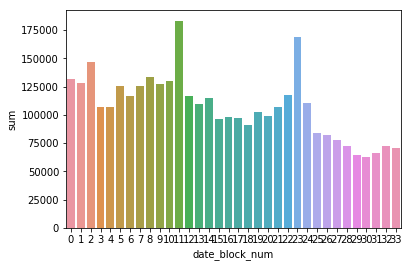

In [6]:
gb = train.groupby(by=['date_block_num'], as_index=False).agg({ 'item_cnt_day': ['sum']})
sns.barplot(x=gb['date_block_num'], y=gb['item_cnt_day']['sum'])

Most of the target values are just Zeros.

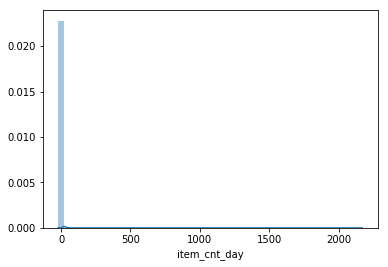

In [7]:
sns.distplot(train['item_cnt_day'])

Zeros and ones are just dominating.

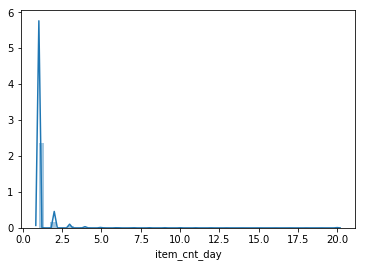

In [8]:
sns.distplot( train[ train['item_cnt_day'] > 0 ]['item_cnt_day'].clip(0, 20) )

# Calculating different aggregations

In [9]:
gb = train.groupby(by=groupby_cols, as_index=False).agg({ 'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target'}, inplace=True)
df = pd.merge(df, gb, how='left', on=groupby_cols)

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_item'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

gb = train.groupby(by=['date_block_num', 'shop_id'], as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_shop'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'shop_id'])

gb = train.groupby( by=['date_block_num', 'cat'], as_index=False).agg({ 'item_cnt_day': ['sum'] })
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_cat'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'cat'])

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_price':['mean', 'max']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_price_mean':'target_price_mean', 'item_price_max':'target_price_max'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

# Clipping some outlier prices

In [10]:
df['target_price_mean'] = np.minimum(df['target_price_mean'], df['target_price_mean'].quantile(0.99))
df['target_price_max'] = np.minimum(df['target_price_max'], df['target_price_max'].quantile(0.99))

df.fillna(0, inplace=True)
df['target'] = df['target'].clip(0, 20)
df['target_zero'] = (df['target'] > 0).astype("int32")

e:\pycharmproject\dsai\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in minimum
  """Entry point for launching an IPython kernel.
e:\pycharmproject\dsai\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in minimum
  


# Mean Encodings

In [11]:
%%time
for enc_cols in [['shop_id', 'cat'], ['shop_id', 'item_id'], ['shop_id'], ['item_id']]:
    
    col = '_'.join(['enc', *enc_cols])
    col2 = '_'.join(['enc_max', *enc_cols])
    df[col] = np.nan
    df[col2] = np.nan
    
    print(col, col2)
    
    for d in tqdm_notebook(df.date_block_num.unique()):
        

        f1 = df.date_block_num < d
        f2 = df.date_block_num == d

        gb = df.loc[f1].groupby(enc_cols)[['target']].mean().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left' )[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col] = enc['target']
        
        gb = df.loc[f1].groupby(enc_cols)[['target']].max().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left' )[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col2] = enc['target']
        

enc_shop_id_cat enc_max_shop_id_cat



enc_shop_id_item_id enc_max_shop_id_item_id



enc_shop_id enc_max_shop_id



enc_item_id enc_max_item_id



Wall time: 4min 46s


In [12]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float32_cols = [c for c in df if df[c].dtype == "float64"]
    int32_cols = [c for c in df if df[c].dtype in ["int64", "int16", "int8"] ]
            
    # Downcast
    df[float32_cols] = df[float32_cols].astype(np.float32)
    df[int32_cols]   = df[int32_cols].astype(np.int32)
        
    return df

In [13]:
df.fillna(0, inplace=True)
df = downcast_dtypes(df)

# Historical values

In [18]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import gc
from time import sleep

groupby_cols = ['date_block_num', 'shop_id', 'item_id']
shift_range = [1, 2, 3, 4, 5, 12]
shifted_columns = [c for c in df if 'target' in c]
print(shifted_columns)

['target', 'target_item', 'target_shop', 'target_cat', 'target_price_mean', 'target_price_max', 'target_zero']


In [23]:
#%%time
for shift in tqdm_notebook(shift_range):
    print(shift)
    shifted_data = df[groupby_cols + shifted_columns].copy()
    shifted_data['date_block_num'] = shifted_data['date_block_num'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in shifted_columns else x
    shifted_data = shifted_data.rename(columns=foo)
    
    
    df = pd.merge(df, shifted_data, how='left', on=groupby_cols).fillna(0)
    df = downcast_dtypes(df)

    del shifted_data
    gc.collect()
    sleep(1)

1
2
3
4
5
12



# Features Interaction
A big breakthrough happened, when i encoded these interactions.

In [24]:
df['target_trend_1_2'] = df['target_lag_1'] - df['target_lag_2']
df['target_predict_1_2'] = df['target_lag_1']*2 - df['target_lag_2']

df['target_trend_3_4'] = df['target_lag_1'] + df['target_lag_2'] - df['target_lag_3'] - df['target_lag_4']
df['target_predict_3_4'] = (df['target_lag_1'] + df['target_lag_2'])*2 - df['target_lag_3'] - df['target_lag_4']

df['target_item_trend_1_2'] = df['target_item_lag_1'] - df['target_item_lag_2']
df['target_item_trend_3_4'] = df['target_item_lag_1'] + df['target_item_lag_2'] - df['target_item_lag_3'] - df['target_item_lag_4']
df['target_shop_trend_1_2'] = df['target_shop_lag_1'] - df['target_shop_lag_2']
df['target_shop_trend_3_4'] = df['target_shop_lag_1'] + df['target_shop_lag_2'] - df['target_shop_lag_3'] - df['target_shop_lag_4']

In [25]:
df = downcast_dtypes(df)
df.to_pickle("df.pkl")

# XGBoost part

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score, roc_curve, roc_auc_score
import gc
import xgboost as xgb
from sklearn.model_selection import train_test_split
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
df = pd.read_pickle("df.pkl")

drop_columns = [c for c in df if c[-1] not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] and c.startswith('target')]
drop_columns += ['ID']
features = df.columns.difference( drop_columns )

f0 = df.date_block_num < 34
f1 = df.date_block_num == 34

train, val = train_test_split(df[f0], test_size=0.2, stratify=df[f0]['target'])
test = df[f1]


In [3]:
Train = xgb.DMatrix( train[features], train['target'] )
Val = xgb.DMatrix( val[features], val['target'] )
Test = xgb.DMatrix( test[features])

e:\pycharmproject\dsai\venv\lib\site-packages\xgboost-0.83.dev0-py3.6.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
e:\pycharmproject\dsai\venv\lib\site-packages\xgboost-0.83.dev0-py3.6.egg\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [4]:
del df
gc.collect()

25

Here are the selected parameters, which turned out to be optimal.

In [5]:
%%time

xgb_params = {'booster': 'gbtree',
          'eta': .1,
          'min_child_weight': 100,
          'max_depth': 6,  ##6
          'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'silent': False,
          'nthread': 8,
          'tree_method': 'gpu_hist'}

model = xgb.train(xgb_params, Train, 1000, [(Train, 'Train'), (Val, 'Val')], early_stopping_rounds=10, verbose_eval=1 )

test['item_cnt_month'] = model.predict(Test).clip(0, 20)
test[['ID', 'item_cnt_month']].sort_values('ID').to_csv('boost_pred.csv', index=False)

[20:46:04] WARNING: C:/dev/libs/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Train-rmse:1.18924	Val-rmse:1.1891
Multiple eval metrics have been passed: 'Val-rmse' will be used for early stopping.

Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Train-rmse:1.14701	Val-rmse:1.14669
[2]	Train-rmse:1.11123	Val-rmse:1.11081
[3]	Train-rmse:1.08084	Val-rmse:1.08035
[4]	Train-rmse:1.05544	Val-rmse:1.05485
[5]	Train-rmse:1.03378	Val-rmse:1.03311
[6]	Train-rmse:1.01555	Val-rmse:1.0148
[7]	Train-rmse:0.999778	Val-rmse:0.998947
[8]	Train-rmse:0.986123	Val-rmse:0.985228
[9]	Train-rmse:0.97511	Val-rmse:0.974233
[10]	Train-rmse:0.965795	Val-rmse:0.965012
[11]	Train-rmse:0.95738	Val-rmse:0.956592
[12]	Train-rmse:0.950346	Val-rmse:0.9496
[13]	Train-rmse:0.944233	Val-rmse:0.943498
[14]	Train-rmse:0.939017	Val-rmse:0.938309
[15]	Train-rmse:0.934614	Val-rmse:0.933898
[16]	Train-rmse:0.930771	Val-rmse:0.930121
[17]	Train-rmse:0.9275

[184]	Train-rmse:0.857118	Val-rmse:0.86227
[185]	Train-rmse:0.857064	Val-rmse:0.862229
[186]	Train-rmse:0.856717	Val-rmse:0.8619
[187]	Train-rmse:0.856593	Val-rmse:0.861805
[188]	Train-rmse:0.856444	Val-rmse:0.861675
[189]	Train-rmse:0.856356	Val-rmse:0.861615
[190]	Train-rmse:0.856206	Val-rmse:0.861458
[191]	Train-rmse:0.856061	Val-rmse:0.861359
[192]	Train-rmse:0.85599	Val-rmse:0.861292
[193]	Train-rmse:0.855931	Val-rmse:0.861243
[194]	Train-rmse:0.855878	Val-rmse:0.861205
[195]	Train-rmse:0.855321	Val-rmse:0.860714
[196]	Train-rmse:0.855181	Val-rmse:0.860592
[197]	Train-rmse:0.855072	Val-rmse:0.860504
[198]	Train-rmse:0.854946	Val-rmse:0.860403
[199]	Train-rmse:0.854849	Val-rmse:0.860325
[200]	Train-rmse:0.854607	Val-rmse:0.860112
[201]	Train-rmse:0.854476	Val-rmse:0.860044
[202]	Train-rmse:0.854391	Val-rmse:0.859963
[203]	Train-rmse:0.854264	Val-rmse:0.859851
[204]	Train-rmse:0.854129	Val-rmse:0.85975
[205]	Train-rmse:0.853779	Val-rmse:0.859419
[206]	Train-rmse:0.853709	Val-rmse:0.

[372]	Train-rmse:0.835508	Val-rmse:0.845181
[373]	Train-rmse:0.835444	Val-rmse:0.845146
[374]	Train-rmse:0.835293	Val-rmse:0.845027
[375]	Train-rmse:0.835203	Val-rmse:0.844939
[376]	Train-rmse:0.835083	Val-rmse:0.844871
[377]	Train-rmse:0.834997	Val-rmse:0.844812
[378]	Train-rmse:0.834877	Val-rmse:0.844716
[379]	Train-rmse:0.834838	Val-rmse:0.844694
[380]	Train-rmse:0.834807	Val-rmse:0.844679
[381]	Train-rmse:0.834701	Val-rmse:0.844577
[382]	Train-rmse:0.834656	Val-rmse:0.844549
[383]	Train-rmse:0.834608	Val-rmse:0.84453
[384]	Train-rmse:0.834553	Val-rmse:0.844487
[385]	Train-rmse:0.834408	Val-rmse:0.844369
[386]	Train-rmse:0.834345	Val-rmse:0.844315
[387]	Train-rmse:0.834287	Val-rmse:0.844269
[388]	Train-rmse:0.834167	Val-rmse:0.84418
[389]	Train-rmse:0.834106	Val-rmse:0.844146
[390]	Train-rmse:0.833982	Val-rmse:0.844071
[391]	Train-rmse:0.833933	Val-rmse:0.844045
[392]	Train-rmse:0.83387	Val-rmse:0.844024
[393]	Train-rmse:0.833819	Val-rmse:0.843992
[394]	Train-rmse:0.833758	Val-rmse:

[560]	Train-rmse:0.819859	Val-rmse:0.833312
[561]	Train-rmse:0.819678	Val-rmse:0.833165
[562]	Train-rmse:0.819598	Val-rmse:0.833076
[563]	Train-rmse:0.819551	Val-rmse:0.833049
[564]	Train-rmse:0.819493	Val-rmse:0.833016
[565]	Train-rmse:0.819448	Val-rmse:0.832995
[566]	Train-rmse:0.819379	Val-rmse:0.832971
[567]	Train-rmse:0.819309	Val-rmse:0.832905
[568]	Train-rmse:0.819277	Val-rmse:0.832903
[569]	Train-rmse:0.819223	Val-rmse:0.832874
[570]	Train-rmse:0.81919	Val-rmse:0.832864
[571]	Train-rmse:0.819152	Val-rmse:0.832862
[572]	Train-rmse:0.81904	Val-rmse:0.83278
[573]	Train-rmse:0.818995	Val-rmse:0.83274
[574]	Train-rmse:0.818962	Val-rmse:0.832727
[575]	Train-rmse:0.818854	Val-rmse:0.832627
[576]	Train-rmse:0.818822	Val-rmse:0.832629
[577]	Train-rmse:0.818767	Val-rmse:0.832592
[578]	Train-rmse:0.818738	Val-rmse:0.832577
[579]	Train-rmse:0.818695	Val-rmse:0.83255
[580]	Train-rmse:0.818648	Val-rmse:0.832535
[581]	Train-rmse:0.818609	Val-rmse:0.832511
[582]	Train-rmse:0.818492	Val-rmse:0.

[748]	Train-rmse:0.809195	Val-rmse:0.826257
[749]	Train-rmse:0.809134	Val-rmse:0.826202
[750]	Train-rmse:0.809129	Val-rmse:0.826201
[751]	Train-rmse:0.809057	Val-rmse:0.826111
[752]	Train-rmse:0.809038	Val-rmse:0.826099
[753]	Train-rmse:0.808989	Val-rmse:0.826076
[754]	Train-rmse:0.808962	Val-rmse:0.82608
[755]	Train-rmse:0.808914	Val-rmse:0.826052
[756]	Train-rmse:0.808874	Val-rmse:0.826045
[757]	Train-rmse:0.808841	Val-rmse:0.826032
[758]	Train-rmse:0.808825	Val-rmse:0.826026
[759]	Train-rmse:0.808746	Val-rmse:0.825964
[760]	Train-rmse:0.808613	Val-rmse:0.825859
[761]	Train-rmse:0.808576	Val-rmse:0.825844
[762]	Train-rmse:0.80838	Val-rmse:0.825683
[763]	Train-rmse:0.808365	Val-rmse:0.825688
[764]	Train-rmse:0.808229	Val-rmse:0.825554
[765]	Train-rmse:0.808194	Val-rmse:0.825531
[766]	Train-rmse:0.808183	Val-rmse:0.82553
[767]	Train-rmse:0.808126	Val-rmse:0.825495
[768]	Train-rmse:0.80807	Val-rmse:0.825461
[769]	Train-rmse:0.808042	Val-rmse:0.825457
[770]	Train-rmse:0.808004	Val-rmse:0

[936]	Train-rmse:0.801027	Val-rmse:0.82113
[937]	Train-rmse:0.800951	Val-rmse:0.821055
[938]	Train-rmse:0.80093	Val-rmse:0.821051
[939]	Train-rmse:0.800736	Val-rmse:0.820875
[940]	Train-rmse:0.800694	Val-rmse:0.820838
[941]	Train-rmse:0.800643	Val-rmse:0.820802
[942]	Train-rmse:0.800617	Val-rmse:0.820785
[943]	Train-rmse:0.800547	Val-rmse:0.820727
[944]	Train-rmse:0.8005	Val-rmse:0.820695
[945]	Train-rmse:0.800487	Val-rmse:0.820691
[946]	Train-rmse:0.800464	Val-rmse:0.820687
[947]	Train-rmse:0.800449	Val-rmse:0.820676
[948]	Train-rmse:0.800392	Val-rmse:0.820644
[949]	Train-rmse:0.800343	Val-rmse:0.820607
[950]	Train-rmse:0.800318	Val-rmse:0.820603
[951]	Train-rmse:0.799917	Val-rmse:0.820238
[952]	Train-rmse:0.799899	Val-rmse:0.82024
[953]	Train-rmse:0.799869	Val-rmse:0.820227
[954]	Train-rmse:0.799851	Val-rmse:0.820224
[955]	Train-rmse:0.799844	Val-rmse:0.820225
[956]	Train-rmse:0.799831	Val-rmse:0.820228
[957]	Train-rmse:0.799801	Val-rmse:0.820212
[958]	Train-rmse:0.799785	Val-rmse:0.

In [6]:
#pickle.dump(model, open("xgb.pickle", "wb"))

In [7]:
#model = pickle.load(open("xgb.pickle", "rb"))

**item_id**, **date_block_num** and **month** have quite a predictive power :)

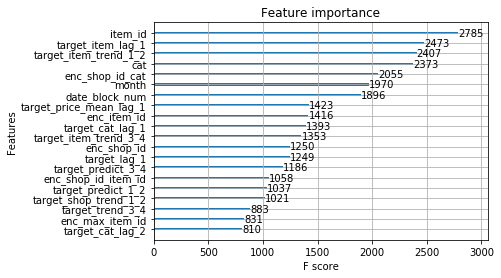

In [9]:
xgb.plot_importance(booster=model, max_num_features=20) ##12

### This method score on LeaderBoard is 0.88338.